In [1]:
from google.colab import drive
from PIL import Image
import scipy.io
import os, glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, MaxPool2D 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 前処理

In [3]:
home_path_train = '/content/drive/My Drive/ml_datasets/Alzheimer_s Dataset/train/'
home_path_test = '/content/drive/My Drive/ml_datasets/Alzheimer_s Dataset/test/'

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 128
EPOCHS = 50

### カテゴリー別表示

In [5]:
# カテゴリ別で、IMAGE数により、該当データセットはunbalancedだとわかりました
# 訓練データ:5121個
categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
for path in categories:
  files = os.listdir(home_path_train + path)
  print(f'{path}:', len(files))

MildDemented: 717
ModerateDemented: 52
NonDemented: 2560
VeryMildDemented: 1792


### インスタンス作成

In [6]:
# インスタンスを作成
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    width_shift_range=0.1, #水平方向への移動範囲
    height_shift_range=0.1, #垂直方向への移動範囲
    rotation_range = 10, #回転角度の範囲
    shear_range = 0.2, #シアー(傾斜角)の範囲
    zoom_range=0.2, #拡大率の範囲
    horizontal_flip=True,
    validation_split=0.2
    )

train_generator = train_datagen.flow_from_directory(
    home_path_train,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), #読み込んだ画像のサイズ
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    subset='training',
    shuffle=True,
    classes=categories
    )

val_generator = train_datagen.flow_from_directory(
    home_path_train,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), #読み込んだ画像のサイズ
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    subset='validation',
    shuffle=True,
    classes=categories
    )

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


### 画像表示

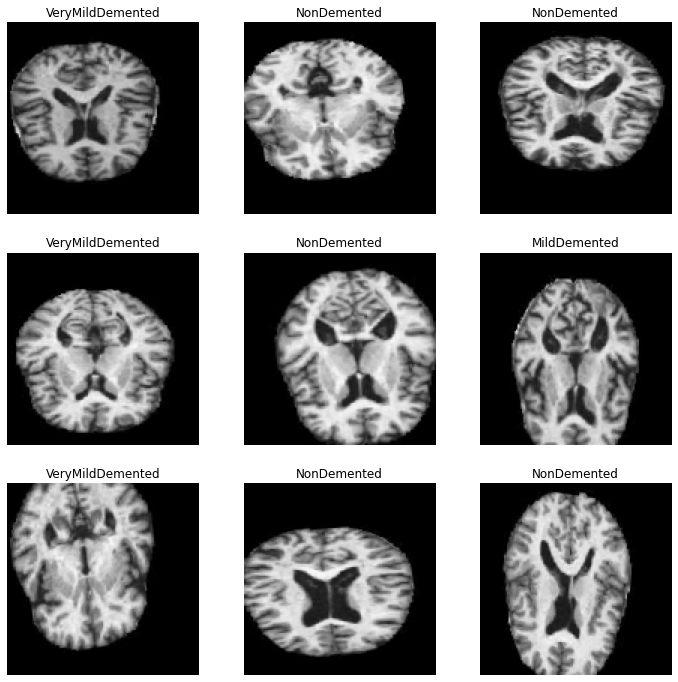

In [7]:
def show_image(image, label):
  plt.figure(figsize=(12, 12))
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image[i])
    plt.title(categories[label[i].tolist().index(1)])
    plt.axis('off')
    
  plt.show()

# テストデータから画像を取得
image, label = next(train_generator)
show_image(image, label)

## モデル

### モデル構築

In [8]:
# 畳込み層構築
def conv_block(filter):
  model = Sequential()
  model.add(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D())

  return model


In [9]:
# 全結合層構築
def dense_block(units, drop):
  model = Sequential()
  model.add(Dense(units, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(drop))

  return model

In [10]:
model = Sequential()
# Input層
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())

# 畳込み層
model.add(conv_block(32))
model.add(conv_block(64))
model.add(conv_block(128))
model.add(Dropout(0.5))
model.add(conv_block(256))
model.add(Dropout(0.5))
model.add(Flatten())

# 全結合層
model.add(dense_block(512, 0.7))
model.add(dense_block(128, 0.5))
model.add(dense_block(64, 0.3))

# Output層
model.add(Dense(4, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 32)        14016     
                                                                 
 sequential_2 (Sequential)   (None, 16, 16, 64)        5

### パラメーター設定

In [12]:
# テスト指標
metrics = [tf.keras.metrics.AUC(name='auc'), 
           tf.keras.metrics.CategoricalAccuracy(name='acc'), 
           tf.keras.metrics.Precision(name="pre"), 
           tf.keras.metrics.Recall(name="rec")]

In [13]:
# Learing_dateのチューニング
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

# 検証データのRecall値をモニター
check_point = ModelCheckpoint(filepath="best_model.h5", monitor='val_rec', mode='max',
                              save_best_only=True, save_best_mode=True)

# 検証データのLoss値をモニター
early_stopping = EarlyStopping(monitor='val_loss', patience=25, 
                               min_delta=0.01, restore_best_weights=True)

In [14]:
# class_weight設定
mild_percent = 717/5121
moderate_percent = 52/5121
non_percent = 2560/5121
veryMild_percent = 1792/5121
class_number = 1/4

class_weight_list = [(class_number/mild_percent)*2, (class_number/moderate_percent)/8,
                     (class_number/non_percent)*2, (class_number/veryMild_percent)*2]

class_weight = {}
for i in range(4):
  class_weight[i] = class_weight_list[i]

print(class_weight)

{0: 3.571129707112971, 1: 3.0775240384615383, 2: 1.0001953125, 3: 1.4288504464285714}


### 訓練

In [15]:
model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=metrics)

In [16]:
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=EPOCHS,
                    callbacks=[early_stopping, check_point, lr_scheduler],
                    class_weight = class_weight)

Epoch 1/50
257/257 [==============================] - 45s 131ms/step - loss: 2.0113 - auc: 0.6947 - acc: 0.3804 - pre: 0.4140 - rec: 0.1816 - val_loss: 1.9597 - val_auc: 0.7666 - val_acc: 0.5093 - val_pre: 0.5079 - val_rec: 0.5034 - lr: 0.0100
Epoch 2/50
257/257 [==============================] - 31s 120ms/step - loss: 1.6766 - auc: 0.7596 - acc: 0.4375 - pre: 0.5443 - rec: 0.2382 - val_loss: 1.3717 - val_auc: 0.6677 - val_acc: 0.3460 - val_pre: 0.3472 - val_rec: 0.3265 - lr: 0.0079
Epoch 3/50
257/257 [==============================] - 34s 132ms/step - loss: 1.6150 - auc: 0.7721 - acc: 0.4449 - pre: 0.5789 - rec: 0.2714 - val_loss: 1.0019 - val_auc: 0.8269 - val_acc: 0.5210 - val_pre: 0.6502 - val_rec: 0.3998 - lr: 0.0063
Epoch 4/50
257/257 [==============================] - 31s 119ms/step - loss: 1.5906 - auc: 0.7917 - acc: 0.4863 - pre: 0.5956 - rec: 0.2875 - val_loss: 1.8214 - val_auc: 0.5370 - val_acc: 0.1398 - val_pre: 0.1399 - val_rec: 0.1398 - lr: 0.0050
Epoch 5/50
257/257 [====

### 性能表示

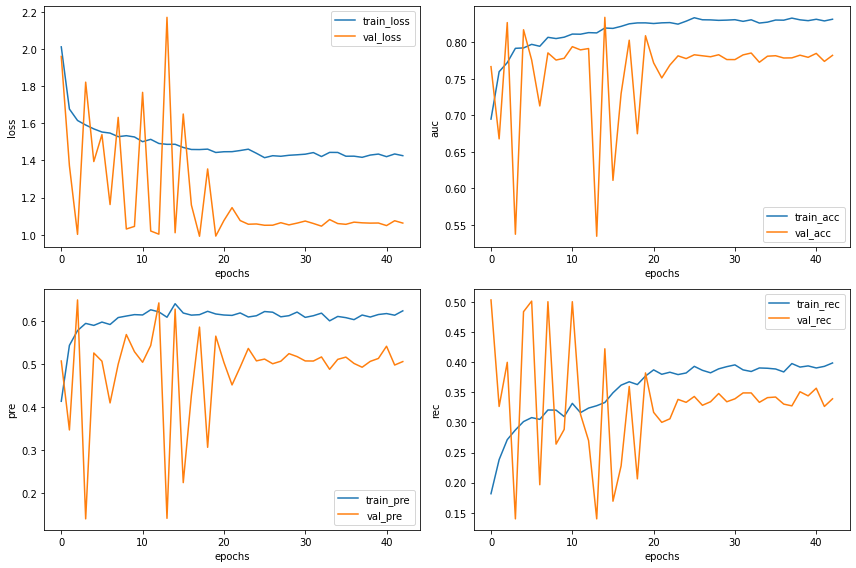

In [17]:
# 性能結果を表示
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
axes[0, 0].plot(train_loss, label='train_loss')
axes[0, 0].plot(val_loss, label='val_loss')
axes[0, 0].set_xlabel('epochs')
axes[0, 0].set_ylabel('loss')
axes[0, 0].legend()

# AUC
train_auc = history.history['auc']
val_auc = history.history['val_auc']
axes[0, 1].plot(train_auc, label='train_acc')
axes[0, 1].plot(val_auc, label='val_acc')
axes[0, 1].set_xlabel('epochs')
axes[0, 1].set_ylabel('auc')
axes[0, 1].legend()

# Precision
train_auc = history.history['pre']
val_auc = history.history['val_pre']
axes[1, 0].plot(train_auc, label='train_pre')
axes[1, 0].plot(val_auc, label='val_pre')
axes[1, 0].set_xlabel('epochs')
axes[1, 0].set_ylabel('pre')
axes[1, 0].legend()

# Recall
train_auc = history.history['rec']
val_auc = history.history['val_rec']
axes[1, 1].plot(train_auc, label='train_rec')
axes[1, 1].plot(val_auc, label='val_rec')
axes[1, 1].set_xlabel('epochs')
axes[1, 1].set_ylabel('rec')
axes[1, 1].legend()

fig.tight_layout()
plt.show()

## テスト評価

### 性能指標

In [19]:
# ソートしない
# テストインスタンスデータ生成
test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    home_path_test,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE)

# 指標OUTPUT
loss, auc, acc, pre, rec = model.evaluate(test_generator)
print("Test Data Loss:", loss)
print("Test Data Auc:", auc)
print("Test Data Accuracy:", acc)
print("Test Data Precision:", pre)
print("Test Data Recall:", rec)

Found 1279 images belonging to 4 classes.
80/80 [==============================] - 3s 36ms/step - loss: 0.9812 - auc: 0.8353 - acc: 0.5403 - pre: 0.6362 - rec: 0.4292
Test Data Loss: 0.9812046885490417
Test Data Auc: 0.8353005051612854
Test Data Accuracy: 0.5402658581733704
Test Data Precision: 0.636152982711792
Test Data Recall: 0.4292415976524353


In [20]:
# ソートしない
# テストデータ予測
test_predict = model.predict(test_generator)

predict_name_list = []
for i in range(test_predict.shape[0]):
  predict_name_list.append(categories[np.argmax(test_predict[i])])

# カテゴリ別の統計
result = Counter(predict_name_list)

print(result)

80/80 [==============================] - 3s 34ms/step
Counter({'NonDemented': 787, 'VeryMildDemented': 378, 'MildDemented': 114})


### ソート

In [21]:
from PIL import Image
import os, glob

categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
x_test = []

for label, category in enumerate(categories):
    dir = home_path_test + category
    files = sorted(glob.glob(dir + '/*.jpg'))
    print(f'{dir}:', len(files))

    for i, file in enumerate(files):
 
        image = Image.open(file)
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
        
        data = np.asarray(image)
        x_test.append(data)
        
x_test = np.asarray(x_test)
x_test = np.expand_dims(x_test, axis=-1) # チャネル数を3にしたなら変更

# テストデータ:1279個、訓練データ:5121個、合わせて：6400個
print(len(x_test))

/content/drive/My Drive/ml_datasets/Alzheimer_s Dataset/test/MildDemented: 179
/content/drive/My Drive/ml_datasets/Alzheimer_s Dataset/test/ModerateDemented: 12
/content/drive/My Drive/ml_datasets/Alzheimer_s Dataset/test/NonDemented: 640
/content/drive/My Drive/ml_datasets/Alzheimer_s Dataset/test/VeryMildDemented: 448
1279


In [22]:
# tensorに変更
x_test = tf.convert_to_tensor(x_test)

# channel:3に変更
x_test = tf.image.grayscale_to_rgb(x_test)

print(x_test.shape)

(1279, 128, 128, 3)


In [23]:
# ソートしたデータのインスタンス
x_test_generator_sorted = ImageDataGenerator(rescale=1.0 / 255).flow(x_test, batch_size=BATCH_SIZE)

In [24]:
# テストデータ予測
test_predict_sorted = model.predict(x_test_generator_sorted)

predict_name_list_sorted = []
for i in range(test_predict_sorted.shape[0]):
  predict_name_list_sorted.append(categories[np.argmax(test_predict_sorted[i])])

# カテゴリ別の統計
result_sorted = Counter(predict_name_list_sorted)

print(result_sorted)

80/80 [==============================] - 1s 7ms/step
Counter({'NonDemented': 765, 'VeryMildDemented': 388, 'MildDemented': 126})


### データ出力

In [25]:
dir = '/content/drive/My Drive/DeepLearning/Report02'

with open(dir + '/test_result.txt', 'w') as f:
    for d in predict_name_list_sorted:
        f.write("%s\n" % d)

In [26]:
np.loadtxt(dir + '/test_result.txt', dtype='str')

array(['VeryMildDemented', 'NonDemented', 'NonDemented', ...,
       'NonDemented', 'NonDemented', 'NonDemented'], dtype='<U16')

### マクロ平均Recall

In [27]:
y_test_true = []

for i in range(179):
  # MildDemented
  y_test_true.append(0)

for i in range(12):
  # ModerateDemented
  y_test_true.append(1)

for i in range(640):
  # NonDemented
  y_test_true.append(2)

for i in range(448):
  # VeryMildDemented
  y_test_true.append(3)

y_test_predict = []
for i in range(test_predict_sorted.shape[0]):
  y_test_predict.append(np.argmax(test_predict_sorted[i]))

In [28]:
from sklearn.metrics import recall_score
recall_score(y_test_true, y_test_predict, average='macro')

0.25711043495610536